# Read Database
read database from "./Mall_Customers.csv" and make simple check.

In [51]:
import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN

data_path = "./Mall_Customers.csv"

df = pandas.read_csv(data_path)

print(df.head())

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [52]:
genre = df['Genre']
for g in genre.unique():
	if g != 'Male' and g != 'Female' :
		print(f"Unknown genre found: {g}")

age = df['Age']
if age.isnull().any():
	print("Missing values found in Age column")

income = df['Annual Income (k$)']
if (income < 0).any():
	print("Negative values found in Annual Income column")

spending_score = df['Spending Score (1-100)']
if (spending_score < 1).any() or (spending_score > 100).any():
	print("Out of range values found in Spending Score column")

customer_ids = df['CustomerID'].unique()
if len(customer_ids) != len(df):
	print("Duplicate CustomerID values found")

# no ouput means all checks passed

In [ ]:
# treat genre as binary variables
# distance is calculated based on numerical values

df['Genre'] = df['Genre'].map({'Male': 0, 'Female': 1})
print(df.head())

   CustomerID  Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1      0   19                  15                      39
1           2      0   21                  15                      81
2           3      1   20                  16                       6
3           4      1   23                  16                      77
4           5      1   31                  17                      40


# Clustering With KMeans

Use KMeans clustering algorithm to cluster the customers based on all features except CustomerID.

Sort clustered points by cluster label and visualize the similar matrix.

Then Determine optimal number of clusters using SSE curve.

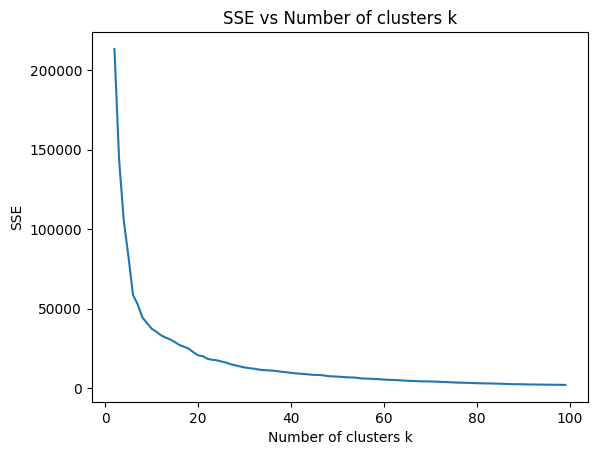

Optimal number of clusters: 6


In [54]:
def sse(points, labels, max_k) :
	centroids : list[np.ndarray] = []
	for k in range(0, max_k) :
		mask = labels == k
		cluster_points = points[mask]
		centroid = np.mean(cluster_points, axis=0)
		centroids.append(centroid)
	
	sse = 0.0
	centroids_arr = np.zeros_like(points)
	for i in range(len(points)) :
		centroids_arr[i] = centroids[labels[i]]
	sse = np.sum((points - centroids_arr) ** 2)
	return sse

sse_hist = []
for max_k in range(2, len(df) // 2) :
	kmeans = KMeans(n_clusters=max_k, random_state=0, max_iter=1000)
	features = df[['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']].to_numpy()
	kmeans.fit(features)
	labels = kmeans.labels_
	sse_value = sse(features, labels, max_k)
	sse_hist.append(sse_value)

plt.plot(range(2, len(df) // 2), sse_hist)
plt.xlabel("Number of clusters k")
plt.ylabel("SSE")
plt.title("SSE vs Number of clusters k")
plt.show()

# select k which slope changes significantly
opt_k = 1
opt_diff = 0
for i in range(2, len(sse_hist) - 1) :
	slope1 = sse_hist[i] - sse_hist[i - 1]
	slope2 = sse_hist[i + 1] - sse_hist[i]
	diff = abs(abs(slope2) - abs(slope1))
	if diff > opt_diff :
		opt_k = i + 2
		opt_diff = diff

print(f"Optimal number of clusters: {opt_k}")

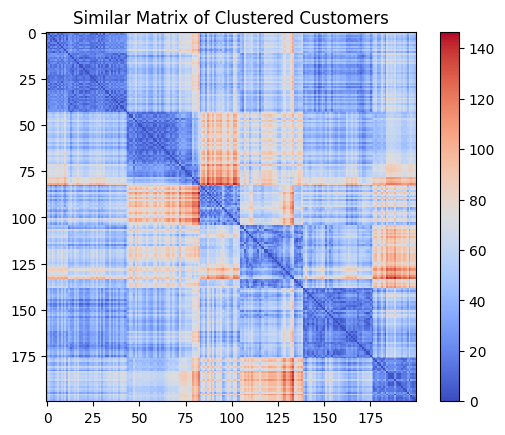

In [55]:
# cluster with optimal k
kmeans = KMeans(n_clusters=opt_k, random_state=0, max_iter=1000)
features = df[['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']].to_numpy()
kmeans.fit(features)
labels = kmeans.labels_

sorted_indices = np.argsort(labels)
sorted_features = features[sorted_indices]

# visualize similar matrix
similar_matrix = np.zeros((len(df), len(df)))
for i in range(len(df)) :
	similar_matrix[i, :] = np.linalg.norm(sorted_features - sorted_features[i], axis=1)

plt.imshow(similar_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Similar Matrix of Clustered Customers")
plt.show()

The similar matrix implies that items in different clusters by KMeans are not distinct enough.

# Clustering With DBSCAN

Do similar things with DBSCAN clustering algorithm.

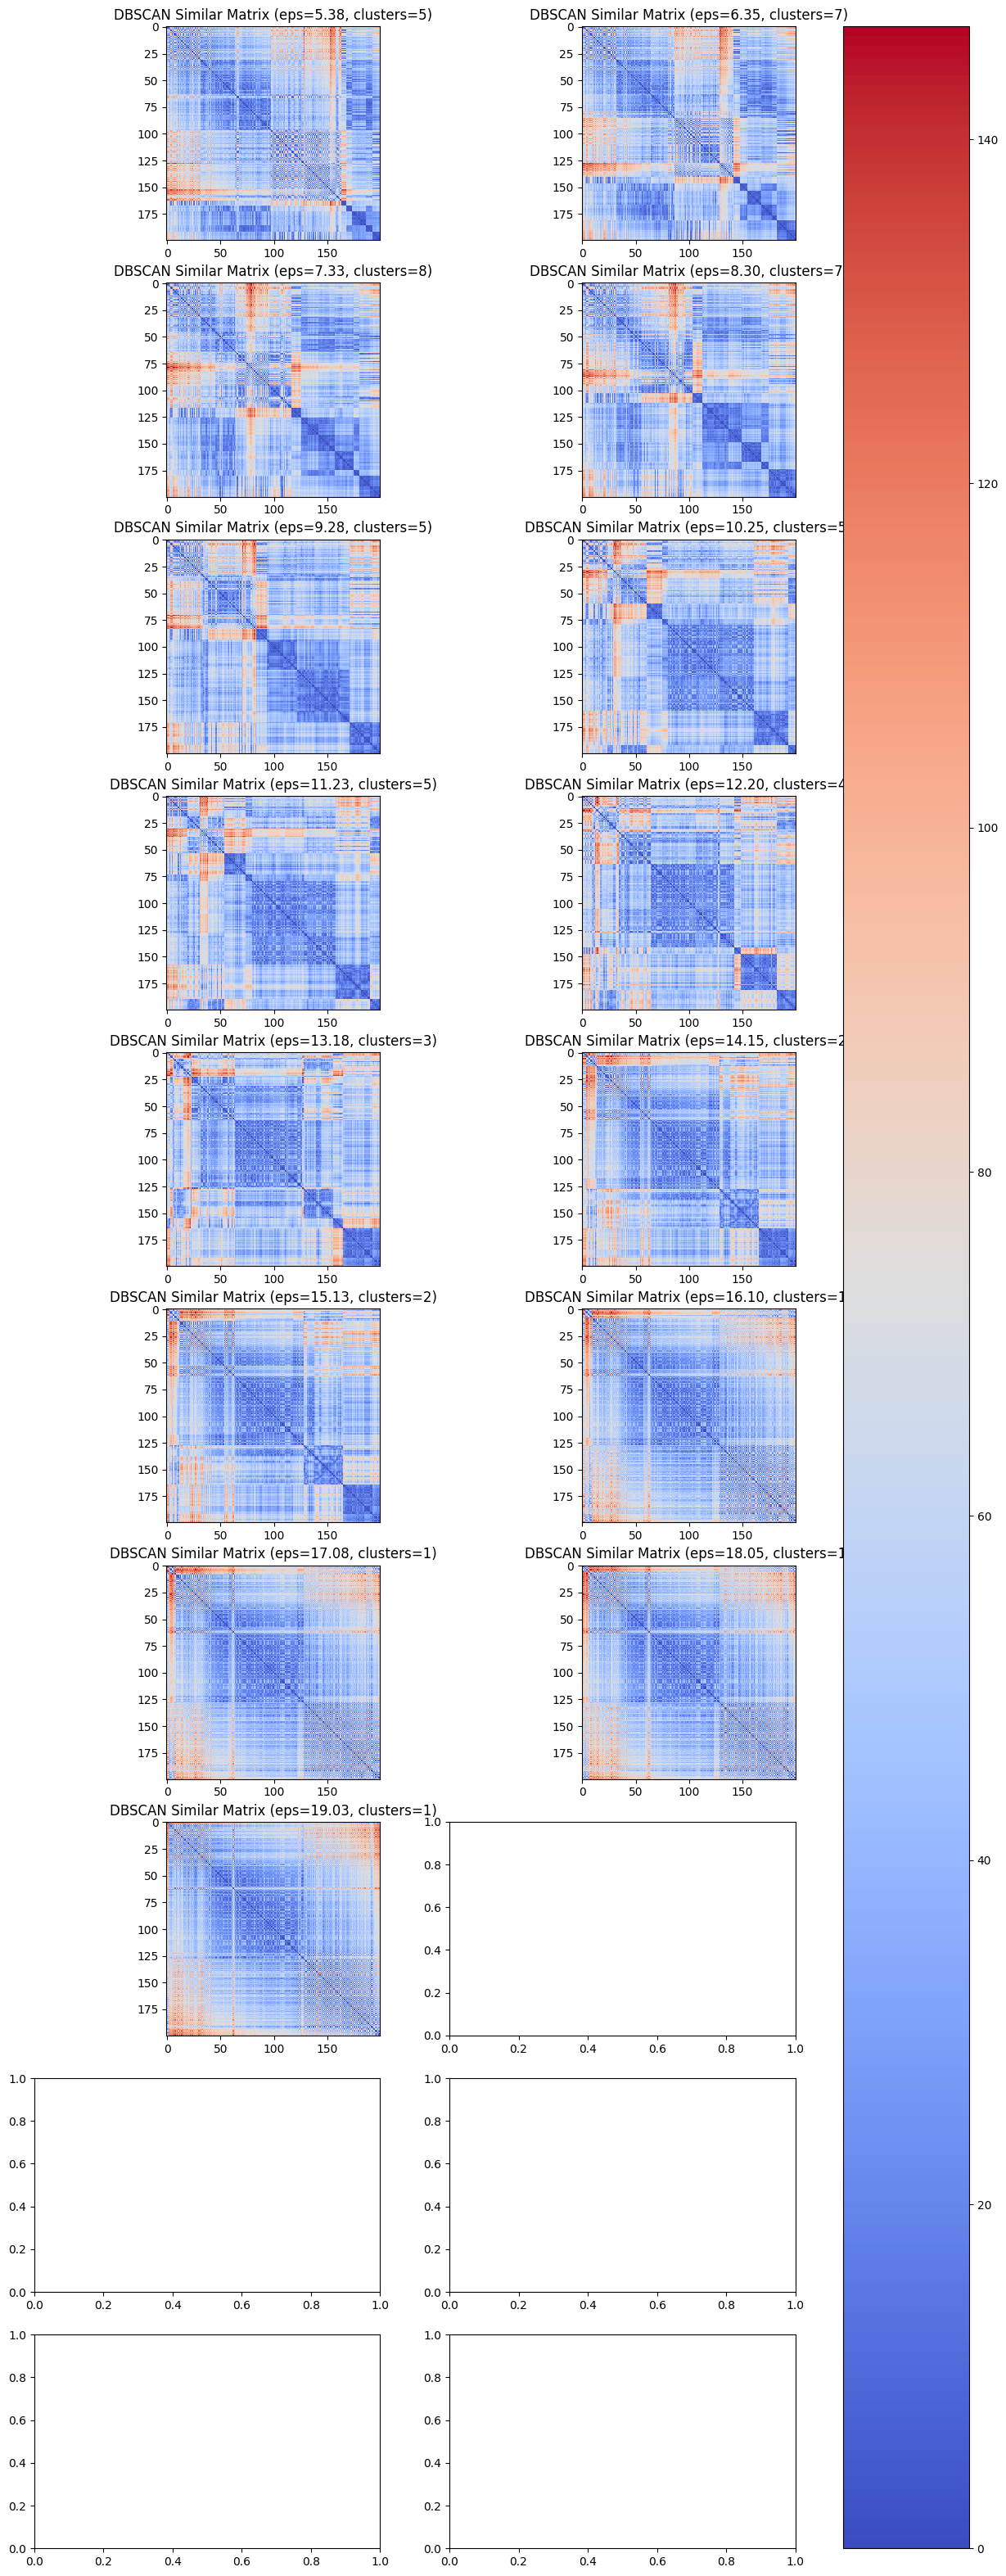

In [63]:
sse_hist_dbscan = []
n_row = 10
n_col = 2

num_attempts = n_row * n_col
similar_matrices_dbscan : list[np.ndarray] = []
cluster_num : list[int] = []

for eps in np.arange(0.5, 20.0, (20.0 - 0.5) / num_attempts) :
	dbscan = DBSCAN(eps=eps, min_samples=5)
	features = df[['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']].to_numpy()
	dbscan.fit(features)
	labels = dbscan.labels_
	# ignore noise points
	unique_labels = set(labels)
	unique_labels.discard(-1)
	num_clusters = len(unique_labels)
	if num_clusters == 0 :
		continue
	sse_value = sse(features, labels, num_clusters)
	sse_hist_dbscan.append((eps, sse_value))

	sorted_indices = np.argsort(labels)
	sorted_features = features[sorted_indices]
	similar_matrix = np.zeros((len(df), len(df)))
	for i in range(len(df)) :
		similar_matrix[i, :] = np.linalg.norm(sorted_features - sorted_features[i], axis=1)
	similar_matrices_dbscan.append(similar_matrix)
	cluster_num.append(num_clusters)
	

# plot similar matrices
fig, axes = plt.subplots(n_row, n_col, figsize=(15, 40))
for i in range(n_row) :
	for j in range(n_col) :
		index = i * n_col + j
		if index >= len(similar_matrices_dbscan) :
			break
		ax = axes[i, j]
		im = ax.imshow(similar_matrices_dbscan[index], cmap='coolwarm', interpolation='nearest')
		ax.set_title(f"DBSCAN Similar Matrix (eps={sse_hist_dbscan[index][0]:.2f}, clusters={cluster_num[index]})")
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()